## Imports

In [1]:
import fsspec
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [17]:
def create_query(date, band='C01'):
    """
    Creates a query for listing GOES16 files stored in AWS bucket
    :param date: date to be queried. e.g datetime(2021, 10, 3, 12). Datetime python object
    :param band: Goes16 band to be queried e.g. C01
    :return: string with a
    """
    prefix = f'ABI-L1b-RadF/{date:%Y}/{date.timetuple().tm_yday}/{date:%H}/OR_ABI-L1b-RadF-M6{band}_G16_s' \
             f'{date:%Y}{date.timetuple().tm_yday}{date:%H}*'
    return prefix


def calc_latlon(ds):
    # The math for this function was taken from
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection

    x, y = np.meshgrid(x, y)

    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi / 180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat

    a = np.sin(x) ** 2 + (np.cos(x) ** 2 * (np.cos(y) ** 2 + (r_eq ** 2 / r_pol ** 2) * np.sin(y) ** 2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H ** 2 - r_eq ** 2

    r_s = (-b - np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)

    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)

    lat = np.arctan((r_eq ** 2 / r_pol ** 2) * (s_z / np.sqrt((H - s_x) ** 2 + s_y ** 2))) * (180 / np.pi)
    lon = (l_0 - np.arctan(s_y / (H - s_x))) * (180 / np.pi)
    ds = ds.assign_coords({"lat": np.nanmax(lat, axis=1),
                           "lon": np.nanmax(lon, axis=0)})
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds

def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((np.nanmin(x), np.nanmax(x)), (np.nanmin(y), np.nanmax(y)))


def goes16_ds(date, band='C01'):
    str_bucket = 's3://noaa-goes16/'
    fs = fsspec.filesystem("s3", anon=True)
    query = create_query(date, band=band)
    files = [fs.open(f"s3://{i}") for i in sorted(fs.glob(f"{str_bucket}{query}"))]
    ds = xr.open_mfdataset(files[:2], engine='h5netcdf', concat_dim='t', combine='nested')
    return calc_latlon(ds)


In [18]:
lats = (-5.5, 16.0)
lons = (-82.0, -66.5)

In [15]:
date = datetime(2023, 4, 10, 12)
ds11 = goes16_ds(date, band="C11")

/tmp/ipykernel_31402/4044553691.py:32: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)
/tmp/ipykernel_31402/4044553691.py:40: RuntimeWarning: All-NaN slice encountered
  ds = ds.assign_coords({"lat": np.nanmax(lat, axis=1),


In [27]:
ds11.keys()

KeysView(<xarray.Dataset>
Dimensions:                                           (t: 2, y: 5424, x: 5424,
                                                       number_of_time_bounds: 2,
                                                       number_of_image_bounds: 2,
                                                       band: 1,
                                                       num_star_looks: 24,
                                                       lat: 5424, lon: 5424)
Coordinates:
  * t                                                 (t) datetime64[ns] 2023...
  * y                                                 (y) float64 0.1518 ... ...
  * x                                                 (x) float64 -0.1518 ......
    y_image                                           float32 0.0
    x_image                                           float32 0.0
    band_id                                           (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelengt

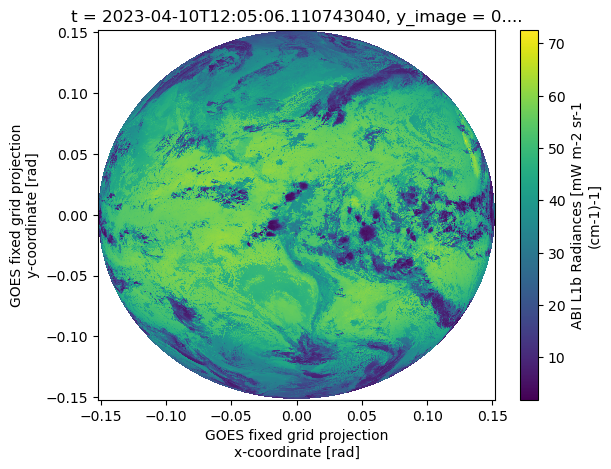

In [28]:
fig, ax = plt.subplots()
ds11.isel(t=0).Rad.plot(ax=ax)